### Title: AR and Seasonal AR Model
https://otexts.org/fpp2/AR.html

Author: Yiran Jing

Date: 27-10-2018

##### Motivation:
Strong first difference and seasonal difference pattern, based on the demand lag plots


##### Variables:
1. power demand


##### Analysis Part: 


In [19]:
library(ggplot2)
library(forecast)
require(ggfortify)
require(ggplot2)
require(forecast)
library(urca)
library(boot)
library(forecast)
library(tidyverse)
library(cowplot)
library(lubridate)


### Stationary data
VAR model need **I(0)** variables! 

decision making based on EDA notebook, the following dataset is stationary already

In [3]:
power = read.csv("../data/shorter_clean_data_26_10_2018.csv")
power = zoo(power[,2:4], order.by = power[,1]) # order by timestap
length(power[,1])

[1] 17451

### Calculate MAPE, MAE for VAR(10) based on test set

In [4]:
train_set= power[ c(1:14542), ] # 2016-05-01 00:30 - 2017-02-28 23:30 
test_set= power[ c(14543:17451), ] # whole test data

### Lag selection

1. AR(1)
2. Seasonal 'AR(48)
3. Seasonal AR(48*7)



In [5]:
length(train_set[,1])

[1] 14542

In [6]:
AR_best = ar(train_set[,1], aic = TRUE)
AR_1 = ar(train_set[,1], FALSE, 1)
AR_48 = ar(train_set[,1], FALSE, 48) 
AR_336 = ar(train_set[,1], FALSE, 336)

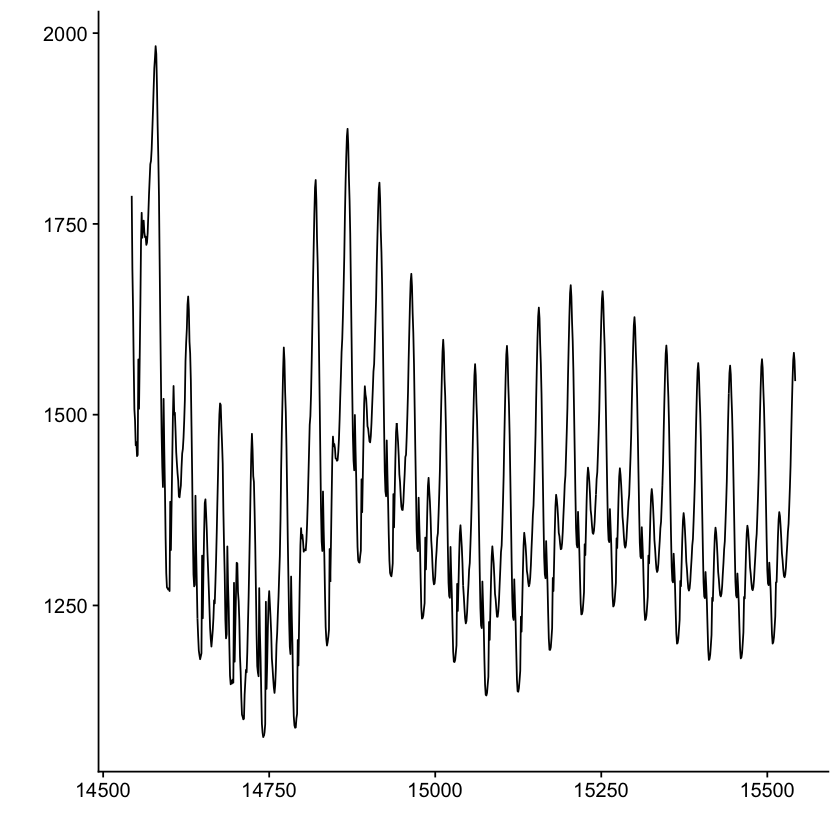

In [42]:
autoplot(predict(AR_336, n.ahead = 1000)$pred)

#### IF want see model result/summary, run the cell below

In [175]:
str(AR_1)

List of 14
 $ order       : num 1
 $ ar          : num 0.962
 $ var.pred    : num 6685
 $ x.mean      : num 1329
 $ aic         : Named num [1:2] 37690 0
  ..- attr(*, "names")= chr [1:2] "0" "1"
 $ n.used      : int 14542
 $ order.max   : num 1
 $ partialacf  : num [1, 1, 1] 0.962
 $ resid       : num [1:14542] NA -84.9 -84.2 -48.4 -59.9 ...
 $ method      : chr "Yule-Walker"
 $ series      : chr "train_set[, 1]"
 $ frequency   : num 1
 $ call        : language ar(x = train_set[, 1], aic = FALSE, order.max = 1)
 $ asy.var.coef: num [1, 1] 5.15e-06
 - attr(*, "class")= chr "ar"


In [176]:
#str(AR_48)

In [177]:
#str(AR_336)

### Model selection By AIC

Intuitively, we try AR(1), and in-day seasonal AR, in-week seasonal AR.

1. Based on AIC plot below, AIC decrease as the order decrease,(see when lag = 336, AIC close to 0) , So just pick lowest AIC model is unreasonable, might just make model complexity/overfitting. 

2. big "jump" at p =48, and after that , AIC decrease slowly, so might in-day seasonal AR is best. but we donot know, and will comfirm in test MAPE part. 

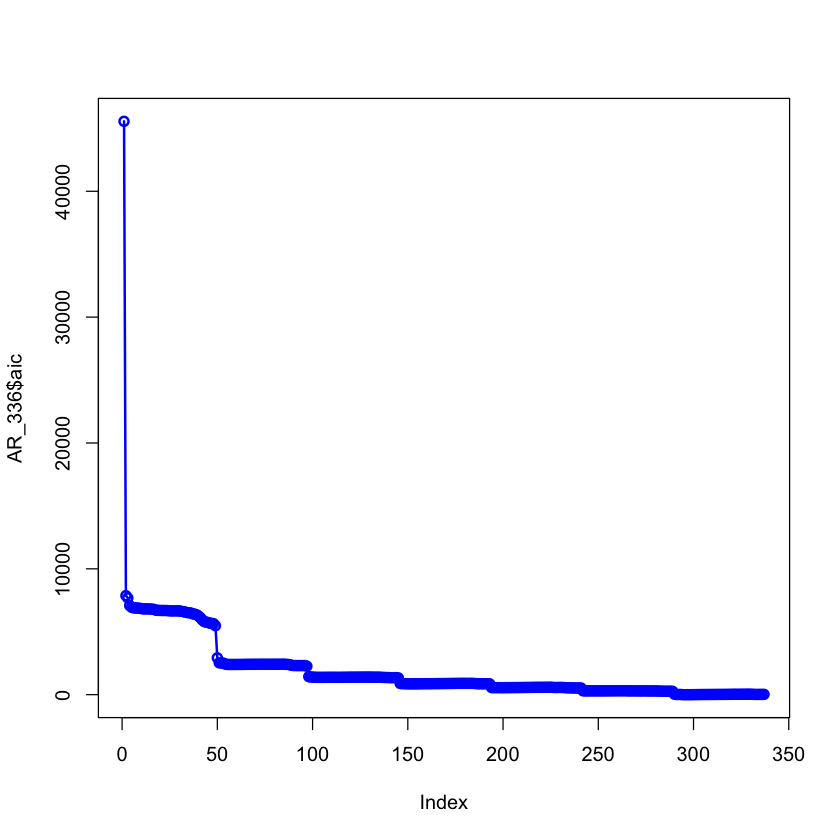

In [164]:
#plot(AR_336$aic, type="o")
plot(AR_336$aic, type="o", lwd=2, col="blue") 

In [144]:
min(AR_best$aic[1:(length(AR_best$aic)-1)]) # order = 41 , select by R

[1] 167.0089

In [145]:
min(AR_1$aic[1:(length(AR_1$aic)-1)])

[1] 37689.72

In [146]:
min(AR_48$aic[1:(length(AR_48$aic)-1)])

[1] 164.4038

In [147]:
min(AR_336$aic[1:(length(AR_336$aic)-1)])

[1] 0

##  TABLE for AIC of AR model 
- AR(1) 37689.7187980367
- AR(41) 167.008948034127
- AR(48) 164.403832035183
- AR(336) close to 0 

In [191]:
actural = train_set[,1]
fit_AR_1 = AR_1$resid
fit_AR_48 = AR_48$resid
fit_AR_336 = AR_336$resid
length(fit_AR_1) = length(actural)
length(fit_AR_48) = length(actural)
length(fit_AR_336) = length(actural)
#Mydata = cbind(actural, fit_AR_1, fit_AR_48, fit_AR_336)
#Mydata1 = merge(actural, fit_AR_1, fit_AR_48, fit_AR_336,drop = FALSE)
Mydata = cbind(fit_AR_1)
write.csv(Mydata, file = "../data/AR1_train_data.csv")
Mydata = cbind(fit_AR_48)
write.csv(Mydata, file = "../data/AR48_train_data.csv")
Mydata = cbind(fit_AR_336)
write.csv(Mydata, file = "../data/AR336_train_data.csv")

### Model diagnostics
Error term should be iid with past and future term, but might correlated bet variables. (i.e. possiblly nonzero off-diagonal elements)

**see another AR notebook**

## Rolling fixed window forecat 
one step ahead

As we select AR(336) model, so just calculate its MAPE by rolling window

In [199]:
time = length(test_set[, 1]) #  two moneth , test data length 
n = length(train_set[, 1]) + time
X = power #  all data


######
##The following code estimates fixed rolling windows with a sample size of (5 months) in each window:
######

# = Number of windows and window size
w_size = length(train_set[, 1])  # fixed window size (6 months, 181 days)
n_windows = length(test_set[, 1])
# initialize list to collect prediction
#(pred_AR_1 <- list())
#(pred_AR_48 <- list())
(pred_AR_336 <- list())
(pred_RW <- list())
(actural <- list())

# = Rolling Window Loop = #
for (i in c(1:n_windows)){
   
  # = Select data for the window (in and out-of-sample) = #
  X_in = X[i:(w_size + i - 1), ] # only first column 
  X_out = X[w_size + i, ]
  
  # Ture value
  actural[[i]] = head(as.numeric(X_out[,1]), 1)
  
  # AR(1) model 
  #AR_1 = ar(X_in[,1], FALSE, 1) 
  #f1 = predict(AR_1, n.ahead = 1) # one step ahead 
 # pred_AR_1  <- append(pred_AR_1, f1$pred[1])

  # AR(48) model Seasonal AR in-day
  #AR_48 = ar(X_in[,1], FALSE, 48) 
  #f3 = predict(AR_48, n.ahead = 1) # one step ahead 
  #pred_AR_48  <- append(pred_AR_48, f3$pred[1])
  
  # AR(336) model Seasonal AR in-week
  AR_336 = ar(X_in[,1], FALSE, 336)
  f4 = predict(AR_336, n.ahead = 1) # one step ahead 
  # HYNDMAN
  pred_AR_336  <- append(pred_AR_336, f4$pred[1])
    
  # = Random Walk One step ahead= # 
  f2 = tail(as.numeric(X_in[,1]), 1)
  ## add prediction result to list
  pred_RW[[i]] <- f2
   
  #print(actural[[i]])
  #print(f1$fcst$demand[,1])
  #print(f2)
  #print('-----------------------------------')
}

list()

list()

list()

In [204]:
length(pred_AR_336)

[1] 2909